In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muhammadshahidazeem/customer-churn-dataset")

print("Path to dataset files:", path)

C:\Users\Yash\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Yash\.cache\kagglehub\datasets\muhammadshahidazeem\customer-churn-dataset\versions\1


In [2]:
import os



In [4]:
path1 = r"C:\Users\Yash\.cache\kagglehub\datasets\muhammadshahidazeem\customer-churn-dataset\versions\1\customer_churn_dataset-training-master.csv"
test_path = r"C:\Users\Yash\.cache\kagglehub\datasets\muhammadshahidazeem\customer-churn-dataset\versions\1\customer_churn_dataset-testing-master.csv"

In [6]:
import pandas as pd 
df_train = pd.read_csv(path1) 
df_train.head() 

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [8]:
df_train.describe() 

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,225398.667955,39.373153,31.256336,15.807494,3.604437,12.965722,631.616223,14.480868,0.567107
std,129531.918550,12.442369,17.255727,8.586242,3.070218,8.258063,240.803001,8.596208,0.495477
min,2.000000,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,113621.750000,29.000000,16.000000,9.000000,1.000000,6.000000,480.000000,7.000000,0.000000
50%,226125.500000,39.000000,32.000000,16.000000,3.000000,12.000000,661.000000,14.000000,1.000000
75%,337739.250000,48.000000,46.000000,23.000000,6.000000,19.000000,830.000000,22.000000,1.000000
max,449999.000000,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


In [10]:
target = df_train["Churn"] 
df = df_train.drop(["CustomerID", "Churn"], axis = 1) 

In [12]:
df.isnull().sum() 

Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
dtype: int64

In [14]:
df.dropna(inplace = True) 

In [16]:
df.isnull().sum() 

Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
dtype: int64

In [18]:
for i in df.columns: 
    if df[i].dtype == "O": 
        print(i)     # findout this are the string data 

Gender
Subscription Type
Contract Length


In [20]:
from sklearn.preprocessing import LabelEncoder

# Initialize a LabelEncoder
le = LabelEncoder()

# Apply label encoding to each categorical column
for column in ['Gender', 'Subscription Type', 'Contract Length']:
    df[column] = le.fit_transform(df[column])

In [24]:
target.dropna(inplace = True) 

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, shuffle = False)


In [28]:
import numpy as np
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score


cat_features = ['Gender', 'Subscription Type', 'Contract Length']  # adjust based on your dataframe

# Initialize and train CatBoost
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=100  # prints training progress every 100 iterations
)

catboost_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50
)

# Make predictions
catboost_preds = catboost_model.predict(X_test)
catboost_pred_proba = catboost_model.predict_proba(X_test)[:, 1]

print(f"CatBoost Accuracy: {accuracy_score(y_test, catboost_preds):.4f}")
print(f"CatBoost AUC: {roc_auc_score(y_test, catboost_pred_proba):.4f}")

# ----------------
# LIGHTGBM MODEL
# ----------------

# Convert data to LightGBM dataset format
# For LightGBM, categorical features should be label-encoded first
# and then specified as categorical
lgb_train = lgb.Dataset(
    X_train, 
    y_train, 
    categorical_feature=cat_features
)
lgb_eval = lgb.Dataset(
    X_test, 
    y_test, 
    reference=lgb_train, 
    categorical_feature=cat_features
)

# Set parameters
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train model
lgb_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=500,
    valid_sets=[lgb_train, lgb_eval],
    callbacks=[lgb.early_stopping(50, verbose=True)]
)

# Make predictions
lgb_preds = np.round(lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration))
lgb_pred_proba = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

print(f"LightGBM Accuracy: {accuracy_score(y_test, lgb_preds):.4f}")
print(f"LightGBM AUC: {roc_auc_score(y_test, lgb_pred_proba):.4f}")

0:	test: 0.0000000	best: 0.0000000 (0)	total: 388ms	remaining: 3m 13s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0
bestIteration = 0

CatBoost Accuracy: 1.0000
CatBoost AUC: nan
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 50 rounds


C:\Users\Yash\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Early stopping, best iteration is:
[1]	training's auc: 0.967835	valid_1's auc: 1
LightGBM Accuracy: 0.0000
LightGBM AUC: nan


C:\Users\Yash\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [30]:
df_test = pd.read_csv(test_path) 
len(df_test)

64374

In [32]:
actual_val = df_test["Churn"]
df_test = df_test.drop(["CustomerID", "Churn"],axis =1 )


In [34]:
for column in ['Gender', 'Subscription Type', 'Contract Length']:
    df_test[column] = le.fit_transform(df_test[column])

In [36]:
df.shape, df_test.shape 

((440832, 10), (64374, 10))

In [42]:
pred = catboost_model.predict(df_test) 
print(f"CatBoost Accuracy: {accuracy_score(actual_val, pred):.4f}")

CatBoost Accuracy: 0.5033


In [40]:
from sklearn.metrics import confusion_matrix



# Compute confusion matrix
cm = confusion_matrix(pred, actual_val) 

print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[ 1946    40]
 [31935 30453]]


In [44]:
total = 64374
a = 1953 + 30453 
a/total 

0.5034019945940907

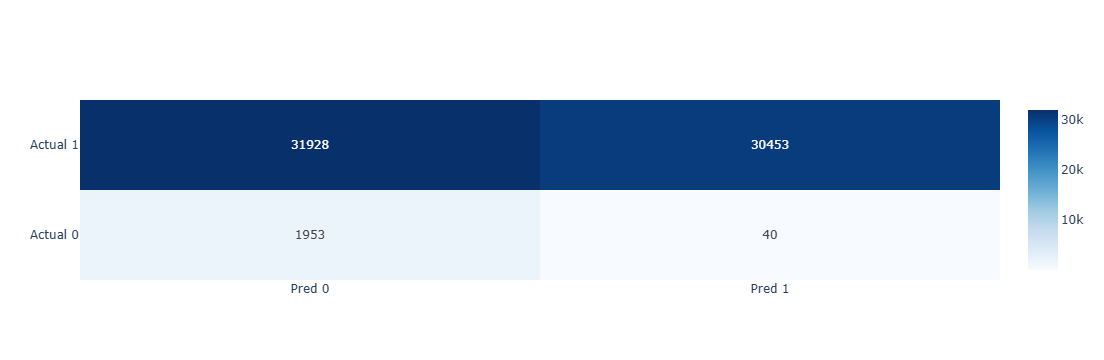

In [55]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
x_labels = ["Pred 0", "Pred 1"]
y_labels = ["Actual 0", "Actual 1"]

# Create Plotly heatmap
fig = go.Figure(data=go.Heatmap(
    z=cm,
    x=x_labels,
    y=y_labels,
    colorscale='Blues',
    showscale=True,
    text=cm,
    texttemplate="%{text}"
))
fig.show() 


In [59]:
df_train.shape

(440833, 12)

In [48]:
from scipy.stats import ks_2samp

def ks_test(train_df, test_df):
    print("KS Test results (p < 0.05 indicates distribution difference):")
    for col in train_df.columns:
        if train_df[col].dtype != 'object':  # Only for numerical
            stat, p = ks_2samp(train_df[col].dropna(), test_df[col].dropna())
            print(f"{col}: KS Statistic={stat:.4f}, p-value={p:.4f}")


In [50]:
ks_test(df, df_test)

KS Test results (p < 0.05 indicates distribution difference):
Age: KS Statistic=0.1466, p-value=0.0000
Gender: KS Statistic=0.1013, p-value=0.0000
Tenure: KS Statistic=0.0259, p-value=0.0000
Usage Frequency: KS Statistic=0.0421, p-value=0.0000
Support Calls: KS Statistic=0.2928, p-value=0.0000
Payment Delay: KS Statistic=0.2394, p-value=0.0000
Subscription Type: KS Statistic=0.0088, p-value=0.0003
Contract Length: KS Statistic=0.0768, p-value=0.0000
Total Spend: KS Statistic=0.2019, p-value=0.0000
Last Interaction: KS Statistic=0.0676, p-value=0.0000


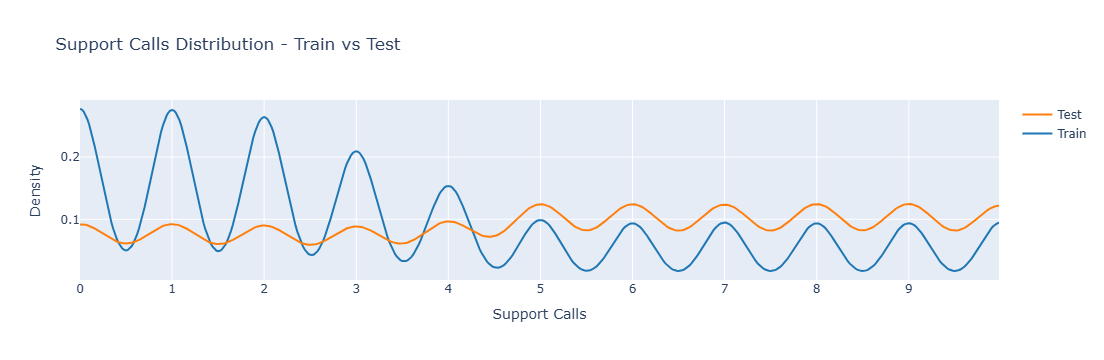

In [52]:
import plotly.figure_factory as ff

# Drop NaNs if needed
train_values = df['Support Calls'].dropna()
test_values = df_test['Support Calls'].dropna()

# Create KDE plot
fig = ff.create_distplot(
    [train_values, test_values],
    group_labels=['Train', 'Test'],
    show_hist=False,
    show_rug=False
)

fig.update_layout(
    title='Support Calls Distribution - Train vs Test',
    xaxis_title='Support Calls',
    yaxis_title='Density'
)

fig.show()


Problem with dataset is that there is huge distribution difference in both of dataset !! That Why I used KDE (Kernel density estimation) for finding it.

The problem can be solved just by adding up the two dataset and model will then will be working more fine way. 